In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = [9., 5.]


#### Definimos: $t(\omega)=\frac{-\kappa}{(\Omega-\omega)-i\kappa+i\frac{g^2}{i(\Delta E-\omega)+\gamma}}$

In [51]:
def t_w (w, k, Omega, DeltaE, gamma, g):
    numerador = -k
    denominador = (Omega-w) - 1j * k + 1j * g**2 / (1j * (DeltaE - w) + gamma)
    t = numerador / denominador
    return abs(t)

 # Sin ruido

## Creamos base de datos

In [52]:
#Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    k = np.random.uniform(1e-4, 1e-2, num_datos)
    DeltaE = np.random.uniform(0.5, 1.5, num_datos)
    gamma = np.random.uniform(1e-4, 1e-2, num_datos)
    g = np.random.uniform(1e-4, 1e-2, num_datos)

    datos = np.column_stack((k, DeltaE, gamma, g))
    #np.savetxt('Parameters_noNoise.txt', datos, header='\u03BA \u03A9 \u0394E \u213D g')

    return datos


In [53]:
num_datos = 5000

datos = Parameters_generator (num_datos)

#Creamos los valores de y (la función t(w)) con nuestra base de datos
w_values = np.linspace(0.85, 1.15, 1000)

Omega = np.ones(num_datos)
k = datos[:,0]
DeltaE = datos[:,1]
gamma = datos[:,2]
g = datos[:,3]

# Crear una matriz para almacenar los t(w)
t_values = np.zeros((num_datos, len(w_values)))

# Almacenar los resultados en la matriz 
# (elemento [i,j] fila i es el número de combinación de [k, DeltaE, gamma, g] 
# y la comluna j el elemento de w_values)
for i in range (num_datos):
    t_values[i,:] = t_w(w_values, k[i], Omega[i], DeltaE[i], gamma[i], g[i])


0.8200409111496597
[0.00603455 0.52276526 0.00084584 0.00871595] 1.004054054054054


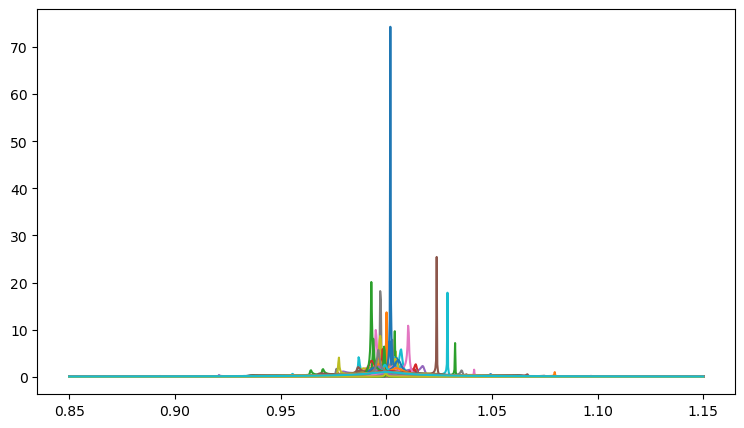

In [54]:
for i in range (num_datos):
    plt.plot(w_values, t_values[i,:])
    
print(t_values[20,513])
print(datos[20], w_values[513])

## Red neuronal

### Tensorflow/Keras

In [55]:
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, AdamW

#### Preparamos datos e hiperparámetros

In [56]:
# #Seleccionamos los datos de entrenamiento y de validación
n_train = int(num_datos*0.8)
n_val = int(num_datos*0.2)

x_train = t_values[0:n_train, :]
y_train = datos[0:n_train, :]
x_val = t_values[n_train:n_train+n_val, :]
y_val = datos[n_train:n_train+n_val, :]

# Comprobamos las dimensiones de nuestros datos
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print("x_train shape",x_train.shape)
print("y_train shape",y_train.shape)

#Número de neuronas de entrada y salida, y de la capa oculta
input_neurons  = x_train.shape[1]
output_neurons = y_train.shape[1]

#Elegimos los hiperparámetros
batch_size = 30
epochs = 40
optimizer = Adam(learning_rate=0.001)


4000 train samples
1000 test samples
x_train shape (4000, 1000)
y_train shape (4000, 4)


#### Definimos modelos

In [57]:
#Definimos el modelo de Red
def Dense_Simple ():
    model = Sequential()
    model.add(Input(shape=(input_neurons,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(output_neurons, activation='linear'))

    #Compila el modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model



#### Encontremos los mejores valores de batch_size y epochs

In [58]:
# from sklearn.model_selection import ParameterGrid
# from sklearn.metrics import mean_squared_error

# # Define el rango de valores para epochs y batch_size que deseas probar
# param_grid = {'epochs': [10, 20, 30, 40], 'batch_size': [10, 25, 50, 100, 500, 1000]}

# # Genera todas las combinaciones posibles de parámetros
# param_combinations = list(ParameterGrid(param_grid))

# # Inicializa las mejores métricas y los mejores parámetros
# best_mae = float('inf')
# best_params = {}

# # Bucle sobre todas las combinaciones de parámetros
# for params in param_combinations:
#     # Crea y compila el modelo con los parámetros actuales
#     model = Dense_Simple()
#     model.compile(optimizer= optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

#     # Ajusta el modelo con los parámetros actuales
#     history = model.fit(x_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'],
#                         validation_data=(x_val, y_val), verbose=2)

#     # Evalúa el modelo en el conjunto de validación
#     mae_score = model.evaluate(x_val, y_val, verbose=0)[1]

#     # Actualiza los mejores parámetros si se encuentra una mejora
#     if mae_score < best_mae:
#         best_mae = mae_score
#         best_params = params

# # Imprime los mejores parámetros encontrados
# print("Mejores parámetros:", best_params)
# print("Mejor MAE:", best_mse)

# # Tarda 7min 13.9s en compilar y devuelve:
# # mejores parámetros {batch_size = 10, epochs = 40}, mejor MAE = 0.018565...

 #### Entrenamos y guardamos

In [59]:
model =  Dense_Simple()

#Fiteamos el modelo
history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_val, y_val),
                     epochs=epochs, verbose=2)

#Guardamos el modelo y así no necesitamos entrenarlo cada vez que lo queramos usar
model.save('model_dense_simple.keras') 



Epoch 1/40


134/134 - 1s - loss: 0.0447 - mean_absolute_error: 0.1146 - val_loss: 0.0446 - val_mean_absolute_error: 0.1016 - 716ms/epoch - 5ms/step
Epoch 2/40
134/134 - 0s - loss: 0.0242 - mean_absolute_error: 0.0807 - val_loss: 0.0395 - val_mean_absolute_error: 0.0871 - 241ms/epoch - 2ms/step
Epoch 3/40
134/134 - 0s - loss: 0.0260 - mean_absolute_error: 0.0926 - val_loss: 0.0407 - val_mean_absolute_error: 0.1038 - 236ms/epoch - 2ms/step
Epoch 4/40
134/134 - 0s - loss: 0.0240 - mean_absolute_error: 0.0841 - val_loss: 0.0370 - val_mean_absolute_error: 0.0872 - 237ms/epoch - 2ms/step
Epoch 5/40
134/134 - 0s - loss: 0.0224 - mean_absolute_error: 0.0772 - val_loss: 0.0383 - val_mean_absolute_error: 0.0806 - 244ms/epoch - 2ms/step
Epoch 6/40
134/134 - 0s - loss: 0.0233 - mean_absolute_error: 0.0829 - val_loss: 0.0396 - val_mean_absolute_error: 0.0914 - 250ms/epoch - 2ms/step
Epoch 7/40
134/134 - 0s - loss: 0.0220 - mean_absolute_error: 0.0777 - val_loss: 0.0424 - val_mean_absolute_error: 0.0923 - 260ms

#### Llamamos y evaluamos

In [60]:
#LLamamos al modelo
model = models.load_model("model_dense_simple.keras")

#model.summary()

#Evaluamos el modelo
scores = model.evaluate(x_val, y_val, verbose=0)
print('MSE',scores[0],'\nMAE:', scores[1])  

#Predecimos los valores con nuestro modelo
y_pred = model.predict(x_val)

MSE 0.02567438594996929 
MAE: 0.07603254169225693
32/32 [==============================] - 0s 934us/step


#### Dibujamos los resultados

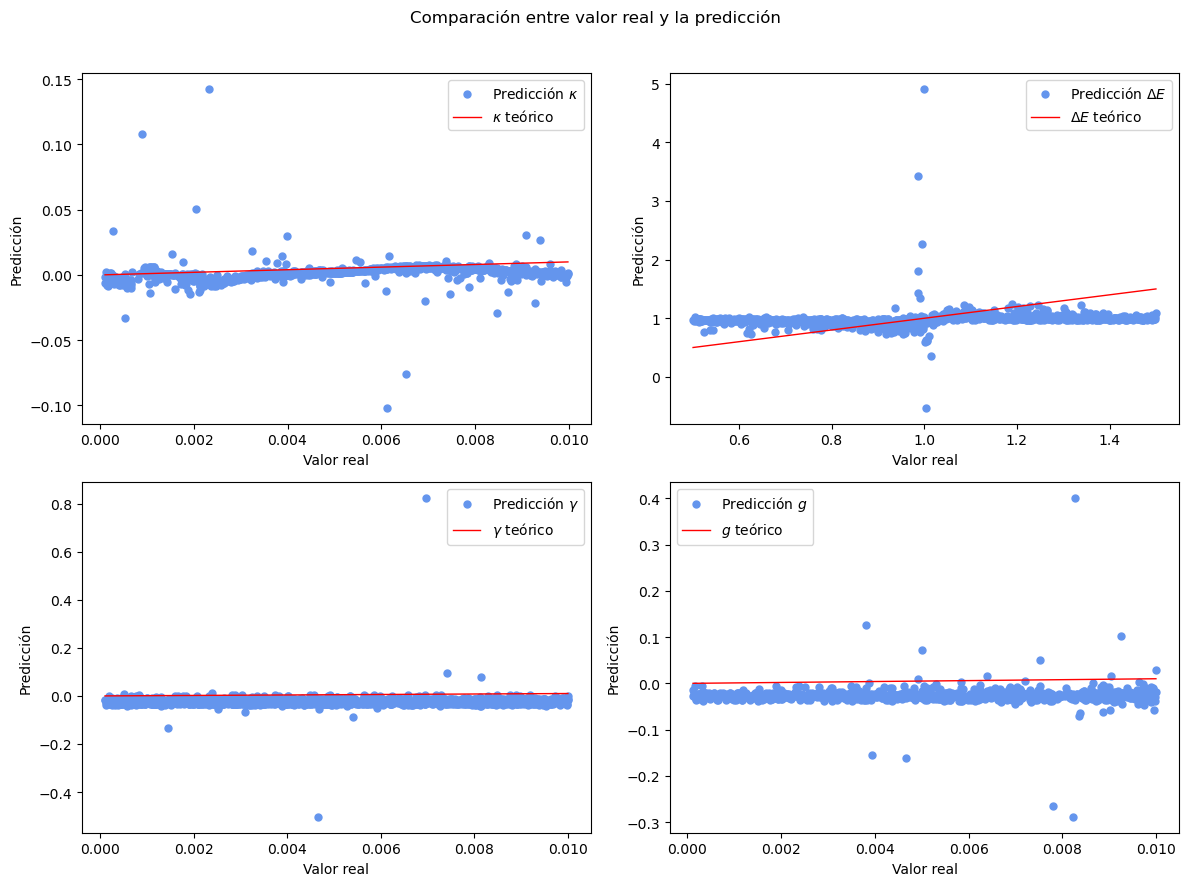

In [61]:
#Dibujamos los datos
symbols = [r'$\kappa$', r'$\Delta E$', r'$\gamma$', r'$g$']

# Crear subgráficos para cada variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
fig.suptitle('Comparación entre valor real y la predicción')

for i, ax in enumerate(axes.flatten()):
    ax.plot(y_val[:, i], y_pred[:, i], label=f'Predicción {symbols[i]}', marker='o', linestyle='',
             markersize=5, color='cornflowerblue')
    ax.plot([y_val[:, i].min(), y_val[:, i].max()], [y_val[:, i].min(), y_val[:, i].max()],
            linestyle='-', color='red', linewidth=1, label=f'{symbols[i]} teórico')
    ax.set_xlabel('Valor real')
    ax.set_ylabel('Predicción')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



#### Predecimos con nueva base de datos


MSE 0.023651277646422386 
MAE: 0.07349254935979843
32/32 [==============================] - 0s 835us/step


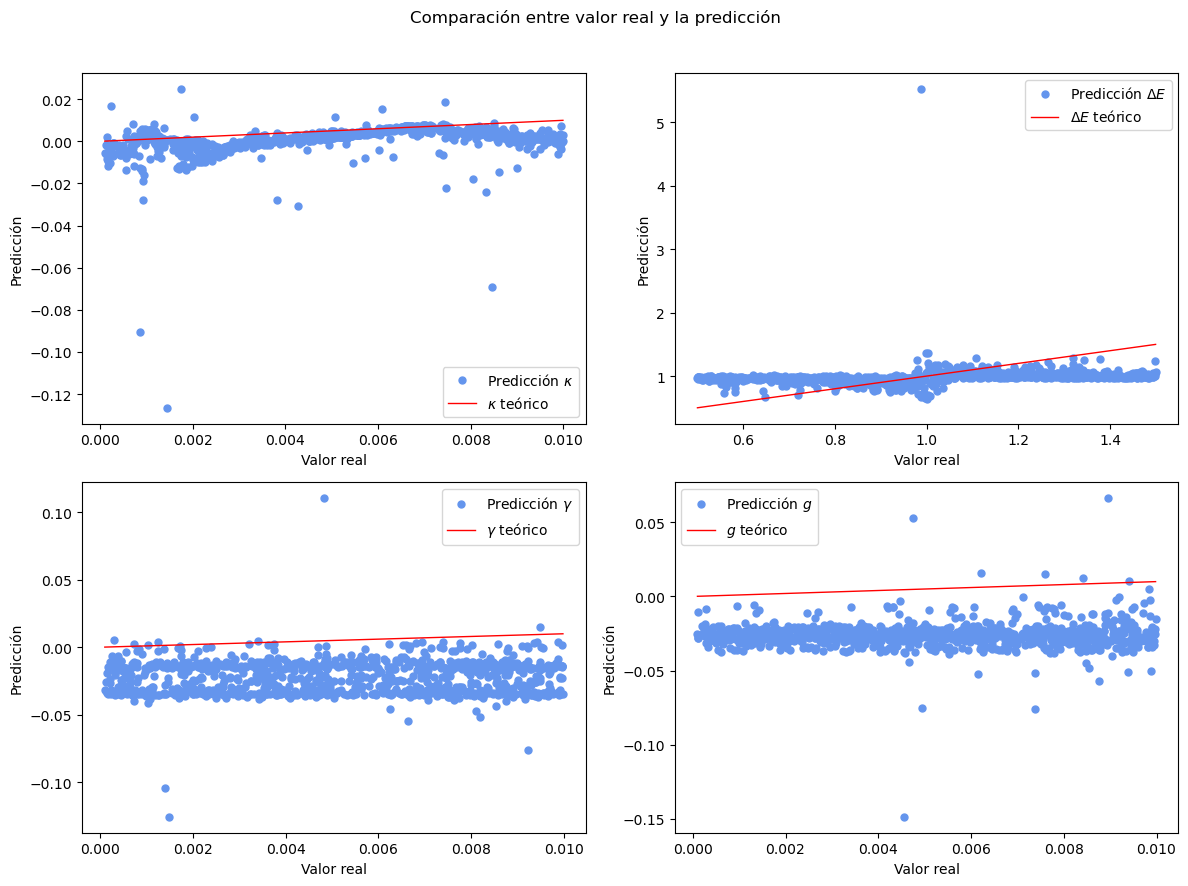

In [62]:
num_datos = 1000

datos = Parameters_generator (num_datos)

Omega = np.ones(num_datos)
k = datos[:,0]
DeltaE = datos[:,1]
gamma = datos[:,2]
g = datos[:,3]

# Crear una matriz para almacenar los t(w)
t_values = np.zeros((num_datos, len(w_values)))

# Almacenar los resultados en la matriz 
# (elemento [i,j] fila i es el número de combinación de [k, DeltaE, gamma, g] 
# y la comluna j el elemento de w_values)
for i in range (num_datos):
    t_values[i,:] = t_w(w_values, k[i], Omega[i], DeltaE[i], gamma[i], g[i])

x_val = t_values
y_val = datos

#LLamamos al modelo
model = models.load_model("model_dense_simple.keras")
#model.summary()

#Evaluamos el modelo
scores = model.evaluate(x_val, y_val, verbose=0)
print('MSE',scores[0],'\nMAE:', scores[1])  

#Predecimos los valores con nuestro modelo
y_pred = model.predict(x_val)

#Dibujamos los datos
symbols = [r'$\kappa$', r'$\Delta E$', r'$\gamma$', r'$g$']

# Crear subgráficos para cada variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
fig.suptitle('Comparación entre valor real y la predicción')

for i, ax in enumerate(axes.flatten()):
    ax.plot(y_val[:, i], y_pred[:, i], label=f'Predicción {symbols[i]}', marker='o', linestyle='',
             markersize=5, color='cornflowerblue')
    ax.plot([y_val[:, i].min(), y_val[:, i].max()], [y_val[:, i].min(), y_val[:, i].max()],
            linestyle='-', color='red', linewidth=1, label=f'{symbols[i]} teórico')
    ax.set_xlabel('Valor real')
    ax.set_ylabel('Predicción')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# With noise